# Parameters

In [3]:
source_folder = '/content/drive/My Drive/gsa_eula_2020_challenge'
destination_folder = '/content/drive/My Drive/gsa_eula_2020_challenge/Model'


# Libraries

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

# NOTE Version of transformers, and torch has to align in order to reload models correctly

Currently have challenge training model on GPU and loading it on CPU macbook

In [22]:
# !pip install torch==1.4.0
!pip install transformers

     |████████████████████████████████| 753.4MB 22kB/s 
ERROR: torchvision 0.7.0+cu101 has requirement torch==1.6.0, but you'll have torch 1.4.0 which is incompatible.
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
ERROR: Operation cancelled by user


KeyboardInterrupt: ignored

In [6]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import torch

# Preliminaries

from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

# Models

import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Preliminaries

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [11]:
# Model parameter
MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('clause_text', text_field),('label', label_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='train.csv', validation='valid.csv',
                                           test='test.csv', format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=16, sort_key=lambda x: len(x.clause_text),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=16, sort_key=lambda x: len(x.clause_text),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=16, device=device, train=False, shuffle=False, sort=False)

Token indices sequence length is longer than the specified maximum sequence length for this model (528 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (524 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6629 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (557 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1141 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

In [12]:
tokenizer.encode('hi my name')

[101, 7632, 2026, 2171, 102]

In [13]:
for (text, labels), _ in train_iter:
  print(text.size())
  break

torch.Size([16, 128])


# Models

In [14]:
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea

# Training

In [15]:
# Save and Load Functions

def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [16]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (text, label), _ in train_loader:
            label = label.type(torch.LongTensor)           
            label = label.to(device)
            text = text.type(torch.LongTensor)  
            text = text.to(device)
            output = model(text, label)
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for (text,label), _ in valid_loader:
                        label = label.type(torch.LongTensor)           
                        label = label.to(device)
                        text = text.type(torch.LongTensor)  
                        text = text.to(device)
                        output = model(text, label)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [17]:
model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)
train(model=model, optimizer=optimizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch [1/5], Step [278/2780], Train Loss: 0.5628, Valid Loss: 0.6737
Model saved to ==> /content/drive/My Drive/gsa_eula_2020_challenge/Model/model.pt
Model saved to ==> /content/drive/My Drive/gsa_eula_2020_challenge/Model/metrics.pt
Epoch [1/5], Step [556/2780], Train Loss: 0.6011, Valid Loss: 0.6862
Epoch [2/5], Step [834/2780], Train Loss: 0.5003, Valid Loss: 0.5724
Model saved to ==> /content/drive/My Drive/gsa_eula_2020_challenge/Model/model.pt
Model saved to ==> /content/drive/My Drive/gsa_eula_2020_challenge/Model/metrics.pt
Epoch [2/5], Step [1112/2780], Train Loss: 0.5119, Valid Loss: 0.5632
Model saved to ==> /content/drive/My Drive/gsa_eula_2020_challenge/Model/model.pt
Model saved to ==> /content/drive/My Drive/gsa_eula_2020_challenge/Model/metrics.pt
Epoch [3/5], Step [1390/2780], Train Loss: 0.4033, Valid Loss: 0.4993
Model saved to ==> /content/drive/My Drive/gsa_eula_2020_challenge/Model/model.pt
Model saved to ==> /content/drive/My Drive/gsa_eula_2020_challenge/Model/

In [21]:
torch.__version__

'1.6.0+cu101'

Model loaded from <== /content/drive/My Drive/gsa_eula_2020_challenge/Model/metrics.pt


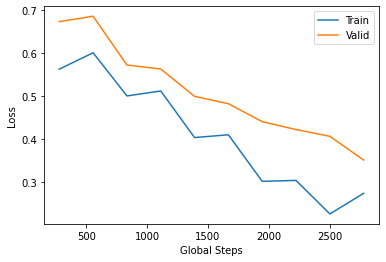

In [18]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

# Evaluation

In [19]:
# Evaluation Function

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for ( text, label), _ in test_loader:

                label = label.type(torch.LongTensor)           
                label = label.to(device)
                text = text.type(torch.LongTensor)  
                text = text.to(device)
                output = model(text, label)

                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(label.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['Good', 'Bad'])
    ax.yaxis.set_ticklabels(['Good', 'Bad'])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== /content/drive/My Drive/gsa_eula_2020_challenge/Model/model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.8084    0.9078    0.8552       618
           0     0.8948    0.7848    0.8362       618

    accuracy                         0.8463      1236
   macro avg     0.8516    0.8463    0.8457      1236
weighted avg     0.8516    0.8463    0.8457      1236



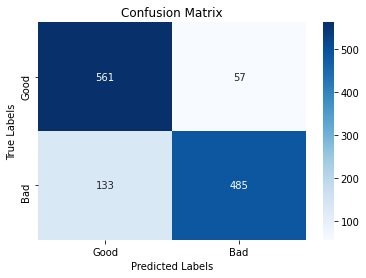

In [20]:
best_model = BERT().to(device)

load_checkpoint(destination_folder + '/model.pt', best_model)

evaluate(best_model, test_iter)

# Text Classification Interpretability

In [26]:
!pip install captum

     |████████████████████████████████| 1.4MB 2.8MB/s 
     |████████████████████████████████| 748.8MB 24kB/s 


In [27]:
from captum.attr import visualization as viz
from captum.attr import IntegratedGradients, LayerConductance, LayerIntegratedGradients
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [28]:
load_checkpoint('/content/drive/My Drive/gsa_eula_2020_challenge/Model/model.pt', model)
model.to(device)
model.eval()
model.zero_grad()

# load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Model loaded from <== /content/drive/My Drive/gsa_eula_2020_challenge/Model/model.pt


In [29]:
def predict(inputs):
    #print('model(inputs): ', model(inputs))
    return model.encoder(inputs)[0]



1.   List item
2.   List item



In [30]:
ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence

In [31]:
def construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id):

    text_ids = tokenizer.encode(text, add_special_tokens=False)
    # construct input token ids
    input_ids = [cls_token_id] + text_ids + [sep_token_id]
    # construct reference token ids 
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(text_ids) + [sep_token_id]

    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(text_ids)

def construct_input_ref_token_type_pair(input_ids, sep_ind=0):
    seq_len = input_ids.size(1)
    token_type_ids = torch.tensor([[0 if i <= sep_ind else 1 for i in range(seq_len)]], device=device)
    ref_token_type_ids = torch.zeros_like(token_type_ids, device=device)# * -1
    return token_type_ids, ref_token_type_ids

def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids
    
def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)

In [32]:
def custom_forward(inputs):
    preds = predict(inputs)
    return torch.softmax(preds, dim = 1)[:, 0] # for negative attribution, torch.softmax(preds, dim = 1)[:, 1] <- for positive attribution

In [34]:
lig = LayerIntegratedGradients(custom_forward, model.encoder.bert.embeddings)

In [57]:
bad_text = """
company warrants that the software for a period of sixty days from the date of your perform substantially in accordance with software written materials accompanying except as just parties acknowledge that the software is provided and may not be functional on every machine or in every except as set forth company disclaims all warranties relating to the express or but not limited any warranties against infringement of third party merchantability and fitness for a particular"""

In [79]:
# text = "the exclusion of implied warranties is not permitted by some the above exclusion may not apply to"# label 0
text= "this license shall be effective until company in its sole and absolute at any time and for any or no disable the or suspend or terminate this license and the rights afforded to you with or without prior notice or other action by upon the termination of this you shall cease all use of the app and uninstall the company will not be liable to you or any third party for or damages of any sort as a result of terminating this license in accordance with its and termination of this license will be without prejudice to any other right or remedy company may now or in the these obligations survive termination of this"
label=1


In [80]:
input_ids, ref_input_ids, sep_id = construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id)
token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
attention_mask = construct_attention_mask(input_ids)

indices = input_ids[0].detach().tolist()
all_tokens = tokenizer.convert_ids_to_tokens(indices)

In [81]:
#saved_act = None
def save_act(module, inp, out):
  #global saved_act
  #saved_act = out
  return saved_act

hook = model.encoder.bert.embeddings.register_forward_hook(save_act)

In [82]:
hook.remove()

In [83]:
# Check predict output
custom_forward(torch.cat([input_ids]))
input_ids.shape

torch.Size([1, 120])

In [84]:
pred = predict(input_ids)
torch.softmax(pred, dim = 1)

tensor([[0.2782, 0.7218]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [85]:
custom_forward(input_ids)

tensor([0.2782], device='cuda:0', grad_fn=<SelectBackward>)

In [86]:
input_ids

tensor([[  101,  2023,  6105,  4618,  2022,  4621,  2127,  2194,  1999,  2049,
          7082,  1998,  7619,  2012,  2151,  2051,  1998,  2005,  2151,  2030,
          2053,  4487, 19150,  1996,  2030, 28324,  2030, 20320,  2023,  6105,
          1998,  1996,  2916, 22891,  2000,  2017,  2007,  2030,  2302,  3188,
          5060,  2030,  2060,  2895,  2011,  2588,  1996, 18287,  1997,  2023,
          2017,  4618, 13236,  2035,  2224,  1997,  1996, 10439,  1998,  4895,
          7076,  9080,  2140,  1996,  2194,  2097,  2025,  2022, 20090,  2000,
          2017,  2030,  2151,  2353,  2283,  2005,  2030, 12394,  1997,  2151,
          4066,  2004,  1037,  2765,  1997, 23552,  2023,  6105,  1999, 10388,
          2007,  2049,  1998, 18287,  1997,  2023,  6105,  2097,  2022,  2302,
         18024,  2000,  2151,  2060,  2157,  2030, 19519,  2194,  2089,  2085,
          2030,  1999,  1996,  2122, 14422,  5788, 18287,  1997,  2023,   102]],
       device='cuda:0')

In [ ]:
attributions_main, delta_main = lig.attribute(inputs=input_ids,
                                    baselines=ref_input_ids,
                                    n_steps=7000,
                                    internal_batch_size=3,
                                    return_convergence_delta=True)

In [ ]:
attributions, delta = lig.attribute(inputs=input_ids,
                                    baselines=ref_input_ids,
                                    n_steps=7000,
                                    internal_batch_size=5,
                                    return_convergence_delta=True)

In [ ]:
torch.sum(attributions_main), torch.sum(attributions)

In [ ]:
delta, delta_main

In [ ]:
score = predict(input_ids)

print('Sentence: ', text)
print('Sentiment: ' + str(torch.argmax(score[0]).cpu().numpy()) + \
      ', Probability Not acceptable: ' + str(torch.softmax(score, dim = 1)[0][1].cpu().detach().numpy()))

In [ ]:
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions

In [ ]:
attributions_sum = summarize_attributions(attributions)

In [ ]:
# storing couple samples in an array for visualization purposes
score_vis = viz.VisualizationDataRecord(attributions_sum,
                                        torch.softmax(score, dim = 1)[0][0],
                                        torch.argmax(torch.softmax(score, dim = 1)[0]),
                                        label,
                                        text,
                                        attributions_sum.sum(),       
                                        all_tokens,
                                        delta)

In [ ]:
score_vis

In [ ]:
print('\033[1m', 'Visualization For Score', '\033[0m')
viz.visualize_text([score_vis])

In [ ]:
 torch.argmax(torch.softmax(score, dim = 1)[0])

In [ ]:
score